In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np                                                              
import pandas as pd      
import geopandas as gpd

import sys
sys.path.append('/Users/Ziqi/Desktop/mgwr-git/')
sys.path.append('/Users/Ziqi/Desktop/spglm-master/')

from mgwr.gwr import GWR,MGWR                                                   
from mgwr.sel_bw import Sel_BW                                                                                                                                                                 

In [2]:
import xgboost
import shap
from sklearn.metrics import mean_squared_error, r2_score

## Simulation data

In [3]:
size = 50

In [4]:
b1 = np.ones(size*size).reshape(size,size)
b2 = np.ones(size*size).reshape(size,size)*3

b2[:33,:] = 1.5
b2[:16,:] = 0

for j in range(size):
    b1[:,j] = j/49*3

b0 = np.zeros((size,size))
for i in range(size):
    for j in range(size):
        b0[i][j] = 3/(12.5**4)*(12.5**2-(12.5-i/2)**2)*(12.5**2-(12.5-j/2)**2)

In [5]:
def plot_1(b,title,vmin=None,vmax=None):
    plt.figure(figsize=(6, 4), dpi=300)
    plt.tight_layout()
    plt.imshow(b.reshape(size,size),vmin=vmin,vmax=vmax)
    plt.title(title,fontsize=13)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([]) 

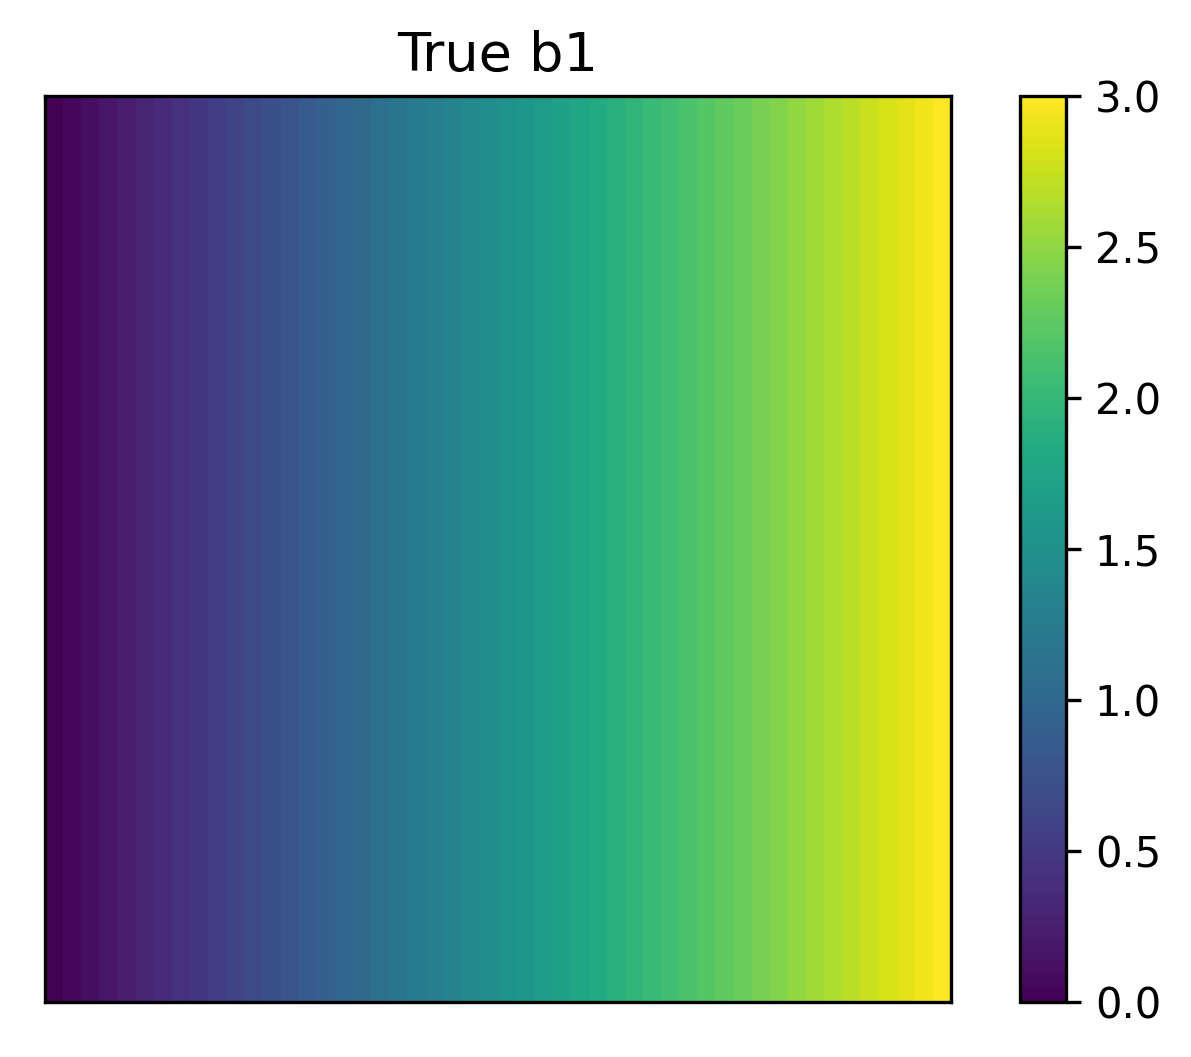

In [6]:
plot_1(b1,'True b1',vmin=0,vmax=3)

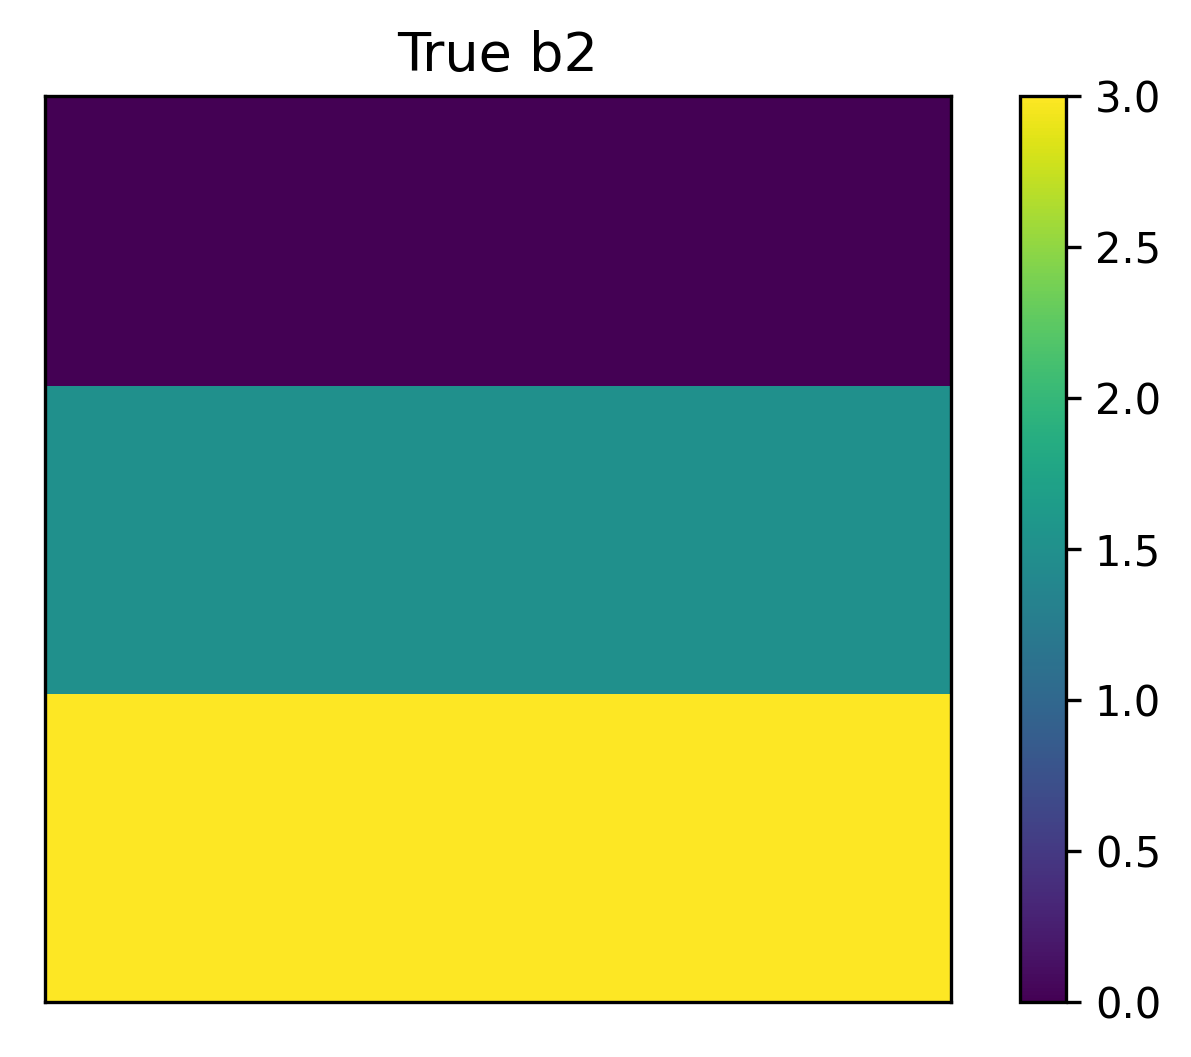

In [7]:
plot_1(b2,'True b2',vmin=0,vmax=3)

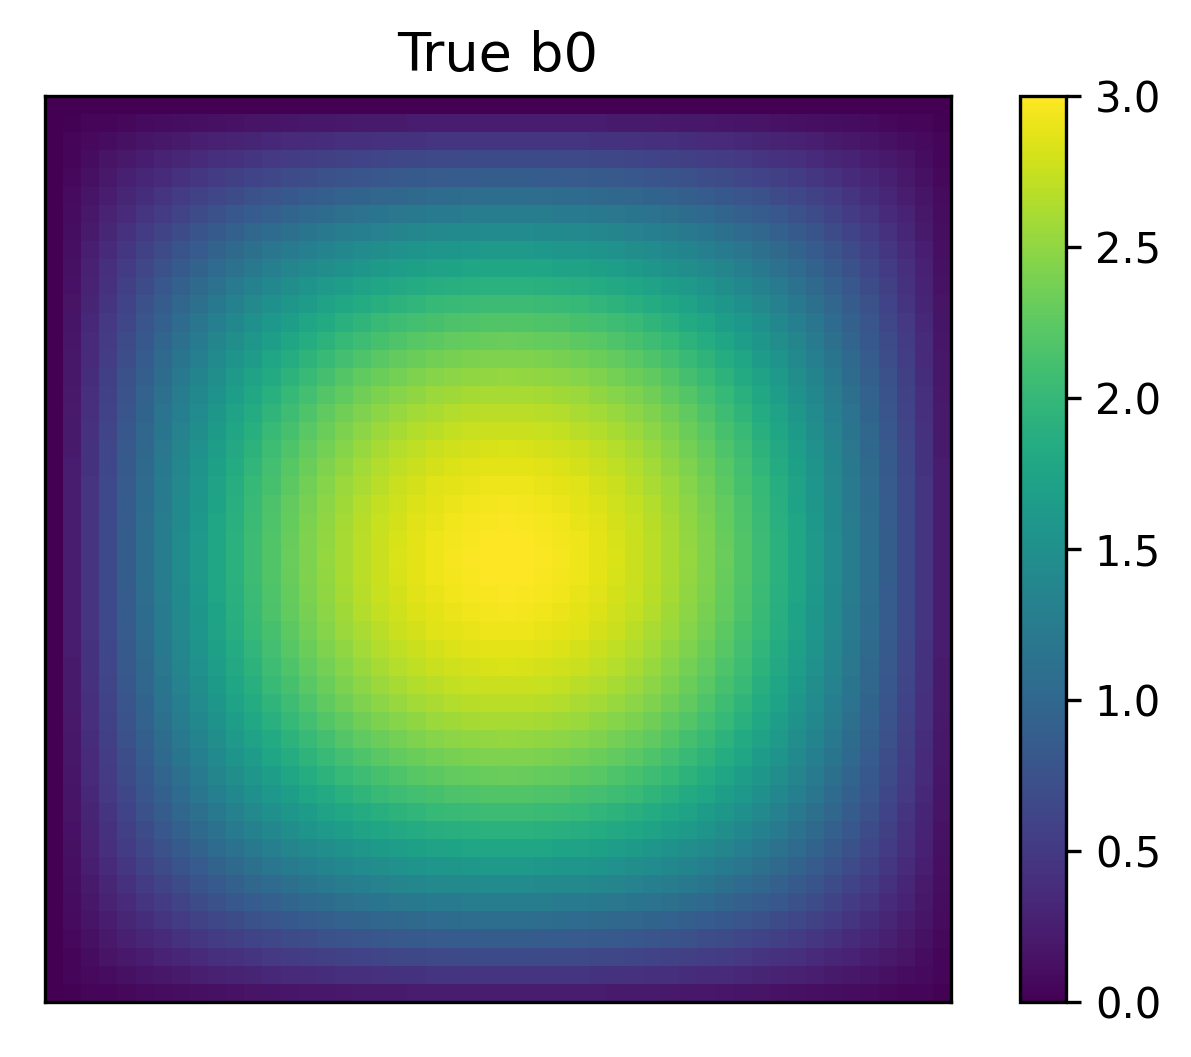

In [8]:
plot_1(b0,'True b0',vmin=0,vmax=3)

In [9]:
np.random.seed(111)

X1 = np.random.uniform(-1.5,1.5,size*size)
X2 = np.random.uniform(-1.5,1.5,size*size)
X3 = np.random.uniform(-1.5,1.5,size*size)

X = np.vstack([X1,X2,X3]).T

u = np.array([np.linspace(0,size-1,num=size)]*size).reshape(-1)
v = np.array([np.linspace(0,size-1,num=size)]*size).T.reshape(-1)
coords = list(zip(u,v))

In [10]:
k = 2;n = size*size

f0 = b0.reshape(-1)
f1 = X1*b1.reshape(-1)
f2 = X2*b2.reshape(-1)
f3 = X3**3
f4 = 2*X1*X2

err = np.random.randn(size*size)*1


y = (f0 + f1 + f2 + f3 + f4 + err).reshape(-1,1)


In [11]:
X_coords = np.hstack([X,coords])

In [12]:
names = ["X1","X2","X3",'x-coord','y-coord']

In [13]:
true_y_pred = f0 + f1 + f2 + f3 + f4
print("True R2:",r2_score(y,true_y_pred))

True R2: 0.9085304820616478


## MGWR

In [14]:
%%time
sel = Sel_BW(coords,y,X,multi=True,constant=True)
bws = sel.search(verbose=False)
result = MGWR(coords,y,X,selector=sel,constant=True).fit()


CPU times: user 8min 19s, sys: 23.6 s, total: 8min 43s
Wall time: 3min 13s


In [15]:
bws

array([ 181.,  134.,   59., 1028.])

In [16]:
result.R2

0.7346219488034669

In [17]:
print(np.sqrt(mean_squared_error(y, result.predy)))

1.724007068011048


In [18]:
print(np.sqrt(np.sum(err**2)/n))

1.0121496677218507


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_coords, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

## XGBoost with hyper-parameter tuning via hyperopt + cross-validation

In [20]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

# Choose hyperparameter domain to search over
space = {
        'max_depth':hp.choice('max_depth', np.arange(1, 31, 1, dtype=int)),
        #'n_estimators':hp.choice('n_estimators', np.arange(40, 2001, 10, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.3, 1.01, 0.05),
        'min_child_weight':hp.choice('min_child_weight', np.arange(1, 31, 1, dtype=int)),
        'subsample':        hp.quniform('subsample', 0.4, 1.01, 0.05),
        'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.6, 0.05)),
        'gamma': hp.quniform('gamma', 0, 3, 0.05),
    
        'objective':'reg:squarederror',
        'eval_metric': 'rmse',
    }

def inner_cv(X_temp, y_temp, n_evals=2000):
    
    def score(params, n_folds=5):
    
        #Cross-validation
        d_train = xgboost.DMatrix(X_temp,y_temp)
    
        cv_results = xgboost.cv(params, d_train, nfold = n_folds,num_boost_round=300,
                        early_stopping_rounds = 10, metrics = 'rmse', seed = 0)
        
        loss = min(cv_results['test-rmse-mean'])
        return loss


    def optimize(trials, space):
    
        best = fmin(score, space, algo=tpe.suggest, max_evals=n_evals,
                rstate=np.random.RandomState(111))#Add seed to fmin function
        return best

    trials = Trials()
    best_params = optimize(trials, space)

    # Return the best parameters
    best_params = space_eval(space, best_params)

    print(best_params)
    return best_params

In [ ]:
%%time
best_params = inner_cv(X_coords, y, n_evals=2000)

  7%|▋         | 138/2000 [13:56<2:41:18,  5.20s/trial, best loss: 1.1263893999999999]

In [ ]:
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)
d_all = xgboost.DMatrix(X_coords,label=y)

In [ ]:
final_model = xgboost.train(best_params,  d_train, num_boost_round=300, evals = [(d_train,"train"),(d_test, "test")],
                      early_stopping_rounds=10,verbose_eval=False)

In [ ]:
y_pred_t = final_model.predict(d_test)

print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred_t)))
print("R2:",r2_score(y_test,y_pred_t))

## Calculating SHAP values

In [ ]:
explainer_shap = shap.TreeExplainer(final_model)
shap_values = explainer_shap(X_coords)

shap_interaction_values = shap.TreeExplainer(final_model).shap_interaction_values(X_coords)

In [ ]:
shap_ins = []

In [ ]:
plt.figure(figsize=(6, 4), dpi=160)
shap.summary_plot(shap_interaction_values, X_coords, max_display=15, 
                  feature_names = names,
                  plot_type="compact_dot")


## Modelled non-linear effect

In [ ]:
plt.figure(figsize=(6, 4), dpi=300)
plt.tight_layout()
plt.title("Estimated partial effect for X3",fontsize=13)
#plt.scatter(shap_values[:,2].data,result.params[:,2]*shap_values[:,2].data,alpha=0.3,label = 'MGWR',color='orange')
plt.scatter(shap_values[:,2].data,shap_values[:,2].values,label = "SHAP-XGBoost")
plt.plot(np.sort(shap_values[:,2].data),np.sort(shap_values[:,2].data)**3,label = "True",color="red",ls="--")
plt.ylabel("SHAP value")
plt.xlabel("X3")
plt.legend(fontsize=10)

## Modelled interaction effect

In [ ]:
plt.figure(figsize=(6, 4), dpi=80)
plt.scatter(shap_values[:,0].data,shap_interaction_values[:,0,1],c=shap_values[:,1].data)
plt.colorbar()

plt.ylabel("SHAP value")
plt.xlabel("X1")

## Spatially varing effects

In [ ]:
f1_est = shap_interaction_values[:,0,-1] + \
         shap_interaction_values[:,-1,0] + \
         shap_interaction_values[:,0,0] + \
         shap_interaction_values[:,0,-2] + \
         shap_interaction_values[:,-2,0]


f2_est = shap_interaction_values[:,1,-1] + \
         shap_interaction_values[:,-1,1] + \
         shap_interaction_values[:,1,1] + \
         shap_interaction_values[:,1,-2] + \
         shap_interaction_values[:,-2,1]

f3_est = shap_values[:,2].values


In [ ]:
plot_1(f1_est.reshape(-1)/(X1),'b1: xgboost',vmin=0,vmax=3)

In [ ]:
plot_1(f2_est.reshape(-1)/(X2),'b2: xgboost',vmin=0,vmax=3)

In [ ]:
plot_1(result.params[:,1],r'Est. $\beta_1$ (MGWR)',vmin=0,vmax=3)

In [ ]:
plot_1(result.params[:,2],r'Est. $\beta_2$ (MGWR)',vmin=0,vmax=3)

In [ ]:
plot_1(result.params[:,3],r'Parameter estimates for X3 (MGWR)')

In [ ]:
f0_est = y.mean() + np.sum(shap_interaction_values[:,3:,3:],axis=(1,2),)

In [ ]:
plot_1(f0_est,'b0: xgboost',vmin=0,vmax=3)

In [ ]:
plot_1(result.params[:,0],r'Est. $\beta_0$ (MGWR)',vmin=0,vmax=3)

In [ ]:
f1_mgwr_est = shap_values[:,0].data*result.params[:,1]
f2_mgwr_est = shap_values[:,1].data*result.params[:,2]
f3_mgwr_est = shap_values[:,2].data*result.params[:,3]

f0_mgwr_est = result.params[:,0]

print(np.round(np.sqrt(mean_squared_error(f0_mgwr_est,f0)),3))
print(np.round(np.sqrt(mean_squared_error(f1_mgwr_est,f1)),3))
print(np.round(np.sqrt(mean_squared_error(f2_mgwr_est,f2)),3))
print(np.round(np.sqrt(mean_squared_error(f3_mgwr_est,f3)),3))

In [ ]:
print(np.round(np.sqrt(mean_squared_error(f0_est,f0)),3))
print(np.round(np.sqrt(mean_squared_error(f1_est,f1)),3))
print(np.round(np.sqrt(mean_squared_error(f2_est,f2)),3))
print(np.round(np.sqrt(mean_squared_error(f3_est,f3)),3))

In [ ]:
def moving_wind(f1_est,X1,w=2):
    mat = np.zeros((size,size))
    for i in range(size):
        for j in range(size):
            if i == 0 and j == 0:
                top = f1_est.reshape(50,50)[0:2,0:2]
                bot = X1.reshape(50,50)[0:2,0:2]
                
            if i == 0 and j > 0:
                top = f1_est.reshape(50,50)[0:i+2,j-1:j+2]
                bot = X1.reshape(50,50)[0:i+2,j-1:j+2]
                
            if j == 0 and i > 0:
                top = f1_est.reshape(50,50)[i-1:i+2,0:j+2]
                bot = X1.reshape(50,50)[i-1:i+2,0:j+2]
                
            if i > 0 and j > 0 : 
                top = f1_est.reshape(50,50)[i-1:i+2,j-1:j+2]
                bot = X1.reshape(50,50)[i-1:i+2,j-1:j+2]
            
            m = np.linalg.lstsq(bot.reshape(-1,1), top.reshape(-1,1), rcond=None)[0][0,0]
            if m > 50:
                print(i,j)
            mat[i,j] = m
            
    return mat
    

In [ ]:
plot_1(moving_wind(f1_est,X1),r'Est. $\beta_1$ (smoothed XGBoost)',vmin=0,vmax=3)

In [ ]:
plot_1(moving_wind(f2_est,X2),r'Est. $\beta_2$ (smoothed XGBoost)',vmin=0,vmax=3)

In [ ]:
plot_1(moving_wind(f0_est,np.ones(X1.shape)),r'Est. $\beta_0$ (smoothed XGBoost)',vmin=0,vmax=3)

In [ ]:
sm_shap_0 = moving_wind(f0_est,np.ones(X1.shape)).reshape(-1)
sm_shap_1 = moving_wind(f1_est,X1).reshape(-1)
sm_shap_2 = moving_wind(f2_est,X2).reshape(-1)

print(mean_squared_error(sm_shap_0,b0.reshape(-1)))
print(mean_squared_error(sm_shap_1,b1.reshape(-1)))
print(mean_squared_error(sm_shap_2,b2.reshape(-1)))